In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from PIL import Image

In [2]:
df = pd.read_csv('df.csv', index_col=0)

In [3]:
import torch
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [4]:
import autoencoder

import importlib
importlib.reload(autoencoder)

from autoencoder import Autoencoder

/home/patrick/anaconda3/envs/oam/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/patrick/anaconda3/envs/oam/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN3c105ErrorC2ENS_14SourceLocationESs
  warn(f"Failed to load image Python extension: {e}")


In [5]:
a = Autoencoder().to(device)

In [6]:
from torch.utils.data import Dataset
from torchvision.io import read_image


class OAMDataset(Dataset):
    def __init__(self, 
                 df,
                 transform=None, 
                 target_transform=None):
                     
        self.df = df
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.df)

    def x_y_from_idx(self, idx):
        row = self.df.iloc[idx]
        x = Image.open(row['x'])
        y = Image.open(row['y'])
        return x, y

    def __getitem__(self, idx):
        x, y = self.x_y_from_idx(idx)

        for transform in self.transform:
            x = transform(x)
        for target_transform in self.target_transform:
            y = target_transform(y)
            
        return x, y

def get_split_df(df_path,
                train_split=0.9,
                **kwargs):

    test = pd.read_csv(df_path)

    n_train = int(train_split * len(test))
    train = df.sample(n_train, replace=False)

    test = test.loc[~test.index.isin(train.index)]
                    
    return OAMDataset(train, **kwargs), OAMDataset(test, **kwargs)

In [7]:
from torchvision.transforms import Resize, ToTensor

resize = Resize((224))
to_tensor = ToTensor()

transforms = [to_tensor, resize]

train_dataset, test_dataset = get_split_df('df.csv', transform=transforms, target_transform=transforms)
len(train_dataset) + len(test_dataset) == len(df)

True

In [8]:
from torch.utils.data import DataLoader

bs = 36

train_dataloader = DataLoader(train_dataset, batch_size=bs, shuffle=True, pin_memory=False)
test_dataloader = DataLoader(test_dataset, batch_size=bs, shuffle=True, pin_memory=False)

In [9]:
class run_logger():

    def __init__(self,
                 run_id, 
                 n_epoch, 
                 n_iter):
                     
        self._init(run_id, bs, n_iter)
        

    def _init(self,
             run_id, 
             n_epoch, 
             n_iter):
                 
        self.run_id = run_id
        
        self.log_dir = os.path.join(f'logs/{self.run_id}')
        os.makedirs(self.log_dir, exist_ok=False)
        
        self.loss_matrix = np.zeros((n_epoch, n_iter))

    def save(self):
        out_path = os.path.join(self.log_dir, 'loss_matrix.npy')
        np.save(out_path, self.loss_matrix)

In [10]:
MSE = torch.nn.MSELoss()
opt = torch.optim.Adam(a.parameters(), lr=0.0001)

n_epoch = 28

In [11]:
from tqdm import tqdm
from uuid import uuid4

In [12]:
run_id = str(uuid4())
logger = run_logger(run_id, n_epoch=n_epoch, n_iter=len(train_dataloader))

In [13]:
a.train(True)

lr_reduce_window = 5
lr_rrf = 0.9
lr_erf = 0.5

for epoch in range(n_epoch):
    loop = tqdm(train_dataloader)
    
    for i, (x, y) in enumerate(loop):
        opt.zero_grad()

        x = x.to(device)
        y = y.to(device)
    
        out = a(y)
        
        batch_loss = MSE(out, x)
        
        logger.loss_matrix[epoch][i] = batch_loss.item()

        if i>lr_reduce_window:
            if logger.loss_matrix[epoch][i-lr_reduce_window:i].min() == logger.loss_matrix[epoch][i-lr_reduce_window]:
                opt.defaults['lr'] *= lr_rrf

        batch_loss.backward()
        opt.step()

        loop.set_description(f"Epoch [{epoch}/{n_epoch}]")
        loop.set_postfix(loss=np.mean(logger.loss_matrix[epoch][logger.loss_matrix[epoch]>0]),
                        lr=opt.defaults['lr'])

    if epoch > 0:
        if np.mean(logger.loss_matrix[epoch]) / np.mean(logger.loss_matrix[epoch-1]) > 0.99:
             opt.defaults['lr'] *= lr_erf
    
    logger.save()

Epoch [5/28]:  46%|████▌     | 55/120 [01:02<01:13,  1.13s/it, loss=0.0134, lr=3.75e-10]


KeyboardInterrupt: 

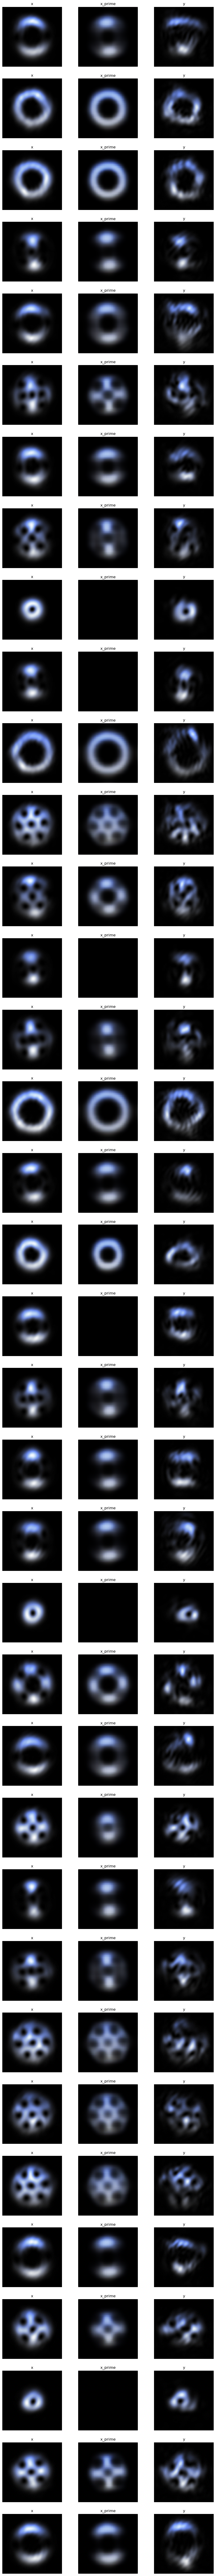

In [14]:
fig, ax = plt.subplots(nrows=bs, ncols=3, figsize=(12,4*bs))

for i in range(bs):
    
    ax[i][0].imshow(x[i].permute(1,2,0).cpu().detach().numpy())
    ax[i][1].imshow(out[i].permute(1,2,0).cpu().detach().numpy())
    ax[i][2].imshow(y[i].permute(1,2,0).cpu().detach().numpy())
    
    ax[i][0].set_title('x')
    ax[i][1].set_title('x_prime')
    ax[i][2].set_title('y')
    
    ax[i][0].axis('off')
    ax[i][1].axis('off')
    ax[i][2].axis('off')

In [ ]:
for i in range(bs):
    plt.plot(logger.loss_matrix[i])